In [18]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get current working directory and project root directory
cwd = os.getcwd()
wd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not wd.endswith('stochastic-travel-demand-modelling'):
    wd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if wd not in sys.path:
    sys.path.append(wd)

from models.singly_constrained.spatial_interaction_model import SpatialInteraction

# Fix seed
np.random.seed(885)

# Import data

In [25]:
# Select dataset
dataset = 'commuter_ward' # 'retail', 'commuter_ward', 'commuter_borough'

# Select cost matrix type
cost_matrix_file = ''


if cost_matrix_file == 'sn':
    cost_matrix_file = '_small_network'

# Select model
constrained = 'singly'

In [26]:
# Import commuter Borough to Borough data
cost_matrix = np.loadtxt(os.path.join(wd,f'data/input/{dataset}/cost_matrix{cost_matrix_file}.txt'))
origin_supply = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/origin_supply.txt'))
initial_destination_sizes = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/initial_destination_sizes.txt'))

# Normalise origin supply, cost matrix and destination sizes
o = origin_supply/np.sum(origin_supply)
c = cost_matrix/np.sum(cost_matrix)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))

# Get origin and destination locations
origin_locs = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/origin_locations.txt'))
destination_locs = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/destination_locations.txt'))

# Read Laplace optimisation parameters
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis{cost_matrix_file}_gamma_10000_parameters.json') as json_file:
    laplace_low_noise_opt_params = json.load(json_file)
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis{cost_matrix_file}_gamma_100_parameters.json') as json_file:
    laplace_high_noise_opt_params = json.load(json_file)
    
# Get dimensions
N,M = cost_matrix.shape

# Construct parameter vector for low noise regime
alpha1 = laplace_low_noise_opt_params['fitted_alpha']
beta1 = laplace_low_noise_opt_params['fitted_scaled_beta']
theta_low_noise = np.array([alpha1,beta1])

# Construct parameter vector for high noise regime
alpha2 = laplace_high_noise_opt_params['fitted_alpha']
beta2 = laplace_high_noise_opt_params['fitted_scaled_beta']
theta_high_noise = np.array([alpha2,beta2])

# Generate initialisations for MCMC sampling

## Low noise

In [27]:
# # Manually set theta_low_noise
# theta_low_noise[0] = 1.2
# theta_low_noise[1] = 0.05

In [28]:
# Select number of samples to generate
n = 100
# Select mcmc start
mcmc_start = 0

# Generate
# theta_low_init = np.random.lognormal(mean=np.log(theta_low_noise),sigma=np.ones(2)*0.1,size=(n,2))
theta_low_init = np.random.lognormal(mean=np.log(theta_low_noise),sigma=np.ones(2)*[0.01,0.1],size=(n,2))
theta_low_init[0,:] = theta_low_noise

# Generate samples from Log Normal distribution cenet
x_low_init = np.log(np.random.lognormal(mean=xd,sigma=np.ones(M)*0.01,size=(n,M)))
sums = [np.sum(x) for x in x_low_init]

# Generate vector of ones for the sign samples
sign_low_init = np.ones((n))

## Theta update step size tuning

In [29]:
# # Theta update step size tuning
# Ap = np.array([[ 0.00749674,  0.00182529], [ 0.00182529,  0.00709968]])
# step = 0.008699999999999998
# idx = 0
# first_proposal = theta_low_init[idx] + step*np.dot(Ap, np.random.normal(0, 1, 2))

# print('Theta opt')
# print(theta_low_noise)

# print('Theta init')
# print(theta_low_init[idx])

# print('First theta transition') 
# print(first_proposal)

## Printing initialisations

In [30]:
print('Theta')
print(theta_low_noise)
print('Theta init')
print(theta_low_init[:mcmc_start+1])

Theta
[1.14 0.1 ]
Theta init
[[1.14 0.1 ]]


In [31]:
# actual_theta_initial = np.loadtxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples_initial.txt"))
# print(actual_theta_initial[:mcmc_start+1])

In [32]:
print('Log size init')
print(x_low_init[:mcmc_start+1])

print('True log size')
print(xd)

Log size init
[[-4.42488776 -3.48825807 -4.11037857 -3.67557687 -3.68867059 -2.74644177
  -2.61012171 -3.37525371 -3.53578661 -3.71527102 -4.17105472 -3.72066482
  -3.62559412 -4.12715745 -4.04573332 -3.93809278 -3.19828335 -3.40929539
  -3.30065893 -3.40280729 -4.03539146 -3.57551612 -4.09689502 -4.05833322
  -4.06068489 -4.01943775 -3.98399279 -3.20448974 -4.08706589 -3.304654
  -4.18406352 -3.61067417 -2.0131484 ]]
True log size
[-4.44068855 -3.50241891 -4.11218448 -3.6760824  -3.69347415 -2.74609283
 -2.60367249 -3.37981659 -3.53183279 -3.72014239 -4.16699272 -3.74754137
 -3.61748824 -4.11218448 -4.04764596 -3.95233578 -3.20931677 -3.4190373
 -3.30570861 -3.42572629 -4.02295335 -3.56213814 -4.11218448 -4.03522344
 -4.06022474 -4.02295335 -3.98702134 -3.18264852 -4.08586717 -3.31167878
 -4.19556609 -3.60939103 -2.01294031]


## Visualise init samples of log destination sizes

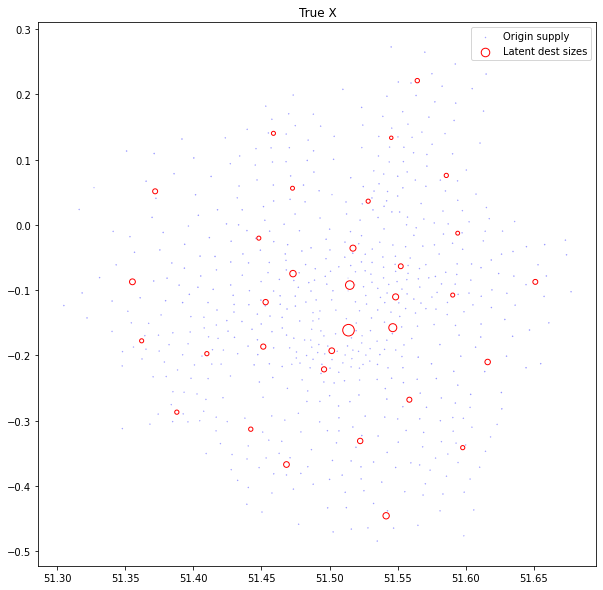

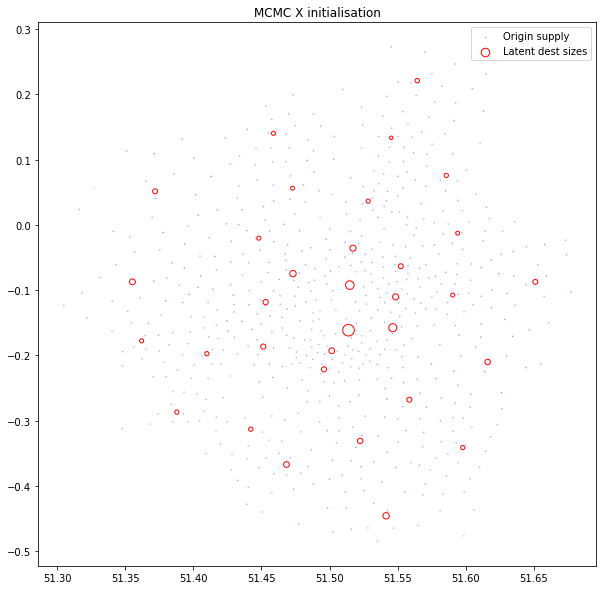

In [33]:
xx = x_low_init[:mcmc_start+1][0]

plt.figure(0,figsize=(10,10))
plt.title("True X")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xd),label='Latent dest sizes')
plt.legend()

plt.figure(1,figsize=(10,10))
plt.title("MCMC X initialisation")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx),label='Latent dest sizes')
plt.legend()

# Export initilisations

In [34]:
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples{cost_matrix_file}_initial.txt"),theta_low_init)
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_logsize_samples{cost_matrix_file}_initial.txt"),x_low_init)
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_sign_samples{cost_matrix_file}_initial.txt"),sign_low_init)
